## 例3. MNIST

`MNIST` の代わりに`FashionMNIST` を用いることもできる．MNISTは易しい課題であるため，MNISTを訓練できるからと言って複雑な課題でも機能する保証はない．とは言え，基本的なデータセットであるため，

簡単なデータでのみweightとnodeを使用．MNISTはnodeのみにする．
Learning curves for stochastic gradient descent in linear feedforward networks.

In [1]:
using Base: @kwdef
using LinearAlgebra, Random, PyPlot, ProgressMeter, Statistics
using MLDatasets
include("../codes/neural_networks.jl")
rc("axes.spines", top=false, right=false)

In [2]:
trainset = MNIST(:train)
X_train, y_train = trainset[:]; # return all observations
println("X_train: $(size(X_train)), y_train: $(size( y_train))")

X_train: (28, 28, 60000), y_train: (60000,)


初回実行時はデータセットのダウンロードを行うか`[y/n]` (yes/no) の入力を求められるので`y`と入力する．

画像の空間次元はflattenする．また，labelは0-9の範囲から1-10の範囲に変更する．

In [3]:
# forward computation of MLP
function forward_perturb!(mlp::MLP, x::Array; mode="weight", σ=1e-2)
    (;L, f, W, b) = mlp
    n_batch = size(x)[1]
    z = Vector{Array}(undef, L+1) # define z (perturbed)
    z[1] = x # input (n_batch x n_neurons)
    # perturbation noise
    if mode == "weight"
        V = [σ * randn(n_batch, size(W[l].v)...) for l in 1:L]
    end
    v = [σ * randn(n_batch, size(b[l].v)[2]) for l in 1:L]
    
    for l in 1:L
        if mode == "weight"
            z[l+1] = f[l](vcat([z[l][i, :]' * (W[l].v + V[l][i, :, :]) for i in 1:n_batch]...) .+ b[l].v + v[l])
        elseif mode == "node"
            z[l+1] = f[l](z[l] * W[l].v .+ b[l].v + v[l])
        end
    end
    if mode == "weight"
        return z[L+1], V, v, σ
    elseif mode == "node"
        return z[L+1], v, σ
    end
end

forward_perturb! (generic function with 1 method)

In [4]:
# t: labels (1 dims)
function cross_entropy_loss(ŷ::Array, t::Vector)
    n_batch = length(t)
    idx = CartesianIndex.([(i, t[i]) for i in 1:n_batch])
    loss = -clog.(ŷ[idx])
    return loss
end

cross_entropy_loss (generic function with 1 method)

In [5]:
# weight
function param_grad!(mlp::MLP, δL, V, v)
    (;L, W, b, z, δ, f) = mlp
    n_batch = size(z[1])[1]
    # backprop
    for l in L:-1:1
        W[l].grad = dropdims(sum(δL .* V[l], dims=1), dims=1)
        b[l].grad = sum(δL .* v[l], dims=1) / n_batch
    end
end

# node
function param_grad!(mlp::MLP, δL, v)
    (;L, W, b, z, δ, f) = mlp
    n_batch = size(z[1])[1]
    # backprop
    for l in L:-1:1
        W[l].grad = (δL .* z[l])' * v[l] / n_batch
        b[l].grad = sum(δL .* v[l], dims=1) / n_batch
    end
end

param_grad! (generic function with 2 methods)

In [6]:
function train_step!(nn::NeuralNet, x::Array, y::Array, loss_fun::Function; optimizer::Optimizer=SGD(), weight_decay=0, mode="weight")
    n_batch = size(x)[1]
    ŷ = nn(x)
    if mode == "weight"
        ŷ_p, V, v, σ = forward_perturb!(nn, x, mode="weight")
    elseif mode == "node"
        ŷ_p, v, σ = forward_perturb!(nn, x, mode="node")
    end
    loss = loss_fun(ŷ, y)
    loss_p = loss_fun(ŷ_p, y)
    δL = (loss_p - loss) / σ
    if mode == "weight"
        param_grad!(nn, δL, V, v)
    elseif mode == "node"
        param_grad!(nn, δL, v)
    end
    optim_step!(nn, optimizer, weight_decay=weight_decay) # update params
    return sum(loss) / n_batch
end

train_step! (generic function with 1 method)

In [7]:
# training data
n_traindata = length(trainset)
n_batch = 200 # batch size
n_iter_per_epoch = round(Int, n_traindata/n_batch)
n_epoch = 10; # number of epoch

X_train = Matrix(reshape(X_train[:, :, 1:n_traindata], (:, n_traindata))') 
y_train = y_train[1:n_traindata] .+ 1; # 0-9 to 1-10

n_classes = 10
model = MLP([28^2, 128, 64, n_classes], [ReLU(), ReLU(), Softmax()]; init_type="He")
loss_fn = cross_entropy_loss

lr = 1e-3  # learning rate
weight_decay = 1e-4 # weight decay (L2 norm) strength
optimizer = Adam(lr=lr);

モデルを定義する．

訓練の途中で学習率を10分の1に減少させる．これを学習率スケジュール (learning rate schedule) という．機械学習においては学習率の変更には線形で減少させる方法，指数関数的に減少させる方法，学習率を振動させる方法 (cosine annealing schedule) などがある．

In [8]:
train_loss = zeros(n_epoch); #training loss of each epoch
for epoch in 1:n_epoch
    # learning rate schedule
    if epoch == round(Int, n_epoch/2)
        optimizer.lr *= 0.1
    end

    # shuffling data
    shuffle_indices = shuffle(1:n_traindata)
    X_train = X_train[shuffle_indices, :];
    y_train = y_train[shuffle_indices]

    # update
    for iter in 1:n_iter_per_epoch
        idx = (iter-1)*n_batch+1:iter*n_batch
        x, y = X_train[idx, :], y_train[idx]
        loss = train_step!(model, x, y, loss_fn, optimizer=optimizer, weight_decay=weight_decay, mode="node")
        train_loss[epoch] += loss
    end
    train_loss[epoch] /= n_iter_per_epoch
    println("[$(lpad(epoch, ndigits(n_epoch), '0'))/$(n_epoch)] train loss: $(train_loss[epoch])")
end

[01/10] train loss: 0.8385840762258224
[02/10] train loss: 0.5188963559119576
[03/10] train loss: 0.5241679675053597
[04/10] train loss: 0.6027197861784159
[05/10] train loss: 0.4180245150063353
[06/10] train loss: 0.3622760542509825
[07/10] train loss: 0.34665659456029235
[08/10] train loss: 0.3325627535642946
[09/10] train loss: 0.3259846239264334
[10/10] train loss: 0.317705042153841


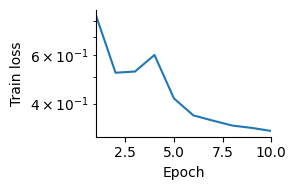

In [9]:
figure(figsize=(3,2))
semilogy(1:n_epoch, train_loss)
ylabel("Train loss"); xlabel("Epoch"); xlim(1, n_epoch)
tight_layout()

学習に使用しなかったデータを用いて，モデルの性能を確認しよう．

In [10]:
testset = MNIST(:test)
X_test, y_test = testset[:]
n_test = length(testset)

x_test = Matrix(reshape(X_test, (28^2, :))')
y_pred = model(x_test) # prediction (label probabilities)
t_pred = getindex.(argmax(y_pred, dims=2), 2) .- 1 # prediction of label
accuracy = sum(t_pred .== y_test) / n_test * 100
println("Test accuracy: $(accuracy)%")

Test accuracy: 91.52%


テストデータでの正答率は概ね98%となった．正答率を上げるには，モデルの中間層のユニットを増やす，Epoch数を増やす，データ拡張 (Data augmentation) を行う，等を行えば可能である．次に混同行列 (Confusion Matrix) を確認する．混同行列はサンプルごとの予測ラベルと正解ラベルを集計した2次元ヒストグラムであり，あるラベルのサンプルを別のラベルであると予測（混同）していないかを確認するものである．モデルの予測性能が高い場合は対角線上の値が大きくなる．

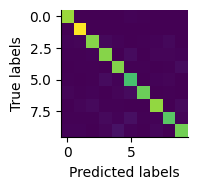

In [11]:
confusion_matrix = zeros(n_classes, n_classes)
for i in 1:n_test
    confusion_matrix[y_test[i]+1, t_pred[i]+1] += 1
end

figure(figsize=(2,2))
imshow(confusion_matrix)
xlabel("Predicted labels")
ylabel("True labels")
tight_layout()

最後に初期層の最初の36個の重みを確認する．

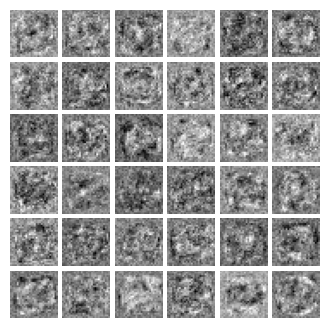

In [12]:
weights = reshape(model.W[1].v'[1:36, :], (36, 28, 28));

fig, axes = subplots(6, 6, figsize=(4,4))
axf = axes[:]
for i in 1:36
    axf[i].imshow(weights[i, :, :], cmap="gray")
    axf[i].axis("off")
end
subplots_adjust(hspace=0.1, wspace=0.1)